In [1]:
# Load necessary libraries
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

# Import additional packages (e.g., numpy) here if your transformations require them

In [2]:
# Set up FRED data connection
# Instructions for getting your FRED API key available at these websites
# https://pypi.org/project/fredapi/ 
# http://api.stlouisfed.org/api_key.html
from fredapi import Fred
fred = Fred(api_key='9a8d4165bcd7fd62acd5724864f5e3dd')

# Choose the FRED series you want to analyze.
FRED_SERIES_ID = 'MORTGAGE30US'  # 30-Year Fixed Rate Mortgage Average in the United States
OBSERVATION_START = '1971-04-02'  # Adjust the time window as needed
OBSERVATION_END = '2025-10-16'

series_info = fred.get_series_info(FRED_SERIES_ID)
series_title = series_info.get('title', FRED_SERIES_ID) if hasattr(series_info, 'get') else FRED_SERIES_ID
series_units = series_info.get('units', '') if hasattr(series_info, 'get') else ''
analysis_label = f"{series_title} ({series_units})" if series_units else series_title

temp = fred.get_series(
    FRED_SERIES_ID,
    observation_start=OBSERVATION_START,
    observation_end=OBSERVATION_END,
)
df_series = (
    pd.DataFrame(data=temp, columns=['value'])
    .rename_axis('Date')
    .reset_index()
    .dropna()
)

period_index = pd.PeriodIndex(pd.to_datetime(df_series['Date']), freq='Weekly')
df_series['Date'] = period_index.to_timestamp(how='start')
df_series = df_series.sort_values('Date').reset_index(drop=True)

print(f"Loaded {FRED_SERIES_ID}: {analysis_label}")
print(df_series.head())
print(df_series.tail())

Loaded MORTGAGE30US: 30-Year Fixed Rate Mortgage Average in the United States (Percent)
        Date  value
0 1971-04-01   7.33
1 1971-04-01   7.54
2 1971-04-01   7.54
3 1971-04-01   7.52
4 1971-04-01   7.46
           Date  value
2842 2025-07-01   6.67
2843 2025-07-01   6.58
2844 2025-10-01   6.30
2845 2025-10-01   6.34
2846 2025-10-01   6.27


In [20]:
# Transform the series for analysis (edit this cell to suit your project)
ANALYSIS_COLUMN = 'MORTGAGE30US'  # Use your preferred column name

full_periods = pd.period_range('1971-04', '2025-10', freq='W')
df_series = (
    df_series.set_index(pd.PeriodIndex(df_series['Date'], freq='W'))
    .reindex(full_periods)
)

df_series.index.name = 'Week'
df_series = df_series.reset_index()
df_series['Date'] = df_series['Week'].dt.to_timestamp(how='start')

df_series[ANALYSIS_COLUMN] = df_series['value']
# Example transformations you can try:
# df_series[ANALYSIS_COLUMN] = df_series['value'].pct_change() * 100  # quarterly percent change
# df_series = df_series.dropna(subset=[ANALYSIS_COLUMN])

print(df_series[['Date', ANALYSIS_COLUMN]].head())
print(df_series[['Date', ANALYSIS_COLUMN]].tail())

ValueError: cannot reindex on an axis with duplicate labels

In [21]:
# Build presidential party flags locally (no download needed)
terms = [
    ("1953-01-20", "1961-01-20", 1),  # Eisenhower (R)
    ("1961-01-20", "1963-11-22", 0),  # Kennedy (D)
    ("1963-11-22", "1969-01-20", 0),  # Johnson (D)
    ("1969-01-20", "1974-08-09", 1),  # Nixon (R)
    ("1974-08-09", "1977-01-20", 1),  # Ford (R)
    ("1977-01-20", "1981-01-20", 0),  # Carter (D)
    ("1981-01-20", "1989-01-20", 1),  # Reagan (R)
    ("1989-01-20", "1993-01-20", 1),  # George H. W. Bush (R)
    ("1993-01-20", "2001-01-20", 0),  # Clinton (D)
    ("2001-01-20", "2009-01-20", 1),  # George W. Bush (R)
    ("2009-01-20", "2017-01-20", 0),  # Obama (D)
    ("2017-01-20", "2021-01-20", 1),  # Trump (R)
    ("2021-01-20", "2025-12-31", 0),  # Biden (D) -- extend through 2025
]

quarter_dates = pd.period_range('1960Q1', '2025Q4', freq='Q').to_timestamp(how='start')
df_gop = pd.DataFrame({'Date': quarter_dates})

def assign_party(ts):
    for start, end, gop_flag in terms:
        if pd.Timestamp(start) <= ts < pd.Timestamp(end):
            return gop_flag
    return 0

df_gop['GOP'] = df_gop['Date'].apply(assign_party).astype(int)
df_gop['Party'] = df_gop['GOP'].map({0: 'Democratic President', 1: 'Republican President'})

print(df_gop.head())
print(df_gop.tail())

        Date  GOP                 Party
0 1960-01-01    1  Republican President
1 1960-04-01    1  Republican President
2 1960-07-01    1  Republican President
3 1960-10-01    1  Republican President
4 1961-01-01    1  Republican President
          Date  GOP                 Party
259 2024-10-01    0  Democratic President
260 2025-01-01    0  Democratic President
261 2025-04-01    0  Democratic President
262 2025-07-01    0  Democratic President
263 2025-10-01    0  Democratic President


In [10]:
# Create new data frame that merges GOP flag with the selected FRED series
df = pd.merge(df_series, df_gop, on='Date', how='left')
df = df.sort_values('Date').reset_index(drop=True)

print(df.head())
print(df.tail())

        Date  value  GOP                 Party
0 1971-04-01   7.33    1  Republican President
1 1971-04-01   7.42    1  Republican President
2 1971-04-01   7.31    1  Republican President
3 1971-04-01   7.31    1  Republican President
4 1971-04-01   7.29    1  Republican President
           Date  value  GOP                 Party
2842 2025-07-01   6.30    0  Democratic President
2843 2025-07-01   6.72    0  Democratic President
2844 2025-10-01   6.34    0  Democratic President
2845 2025-10-01   6.30    0  Democratic President
2846 2025-10-01   6.27    0  Democratic President


KeyError: "['mortage_rate'] not in index"

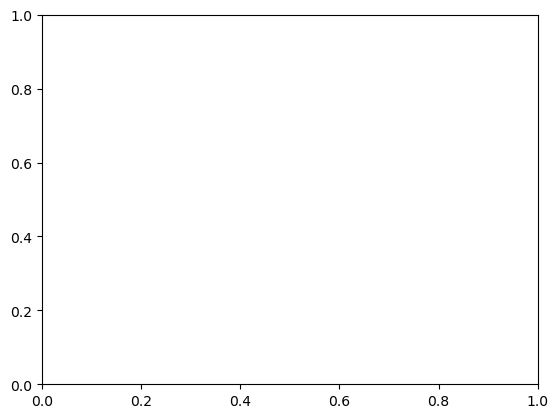

In [12]:
# Plot the indicator over time and shade GOP presidential terms
def plot_series(ax, data, index='Date', col=ANALYSIS_COLUMN, area='GOP', title=None, ylabel=None):
    plot_df = data[[index, col, area]].copy()
    plot_df[area] = plot_df[area].astype(int).astype(bool)
    ax.plot(plot_df[index], plot_df[col], color='blue')
    y1, y2 = ax.get_ylim()
    ax.fill_between(plot_df[index], y1, y2, where=plot_df[area], facecolor='grey', alpha=0.35)
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel or col.replace('_', ' ').title())
    if title:
        ax.set_title(title)
    return ax

# set up figure, axis
f, ax = plt.subplots()
plot_series(ax, df, title=analysis_label)
ax.grid(True)
plt.show()

In [15]:
# Compare average values across parties
party_means = (
    df.groupby('Party')[ANALYSIS_COLUMN]
    .mean()
    .reindex(['Democratic President', 'Republican President'])
)

ax = party_means.plot(kind='bar', color=['royalblue', 'firebrick'], rot=0)
ax.set_ylabel(f'Average {analysis_label}')
ax.set_title('Average real GDP by presidential party')
plt.tight_layout()
plt.show()

KeyError: 'Column not found: MORTGAGE30US'

In [16]:
# Run OLS regression of the indicator onto the GOP president flag
df['GOPlag'] = df['GOP'].shift()
reg_data = df.dropna(subset=['GOPlag', ANALYSIS_COLUMN]).copy()

X = sm.add_constant(reg_data['GOPlag'])
y = reg_data[ANALYSIS_COLUMN]
results = sm.OLS(y, X, missing='drop').fit(cov_type='HC3')
print(results.summary())

KeyError: ['MORTGAGE30US']